## Reference

Custom Dataset classes in pytorch
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

k-Fold validation pytorch
--
1. https://stackoverflow.com/questions/58996242/cross-validation-for-mnist-dataset-with-pytorch-and-sklearn
2. https://discuss.pytorch.org/t/i-need-help-in-this-k-fold-cross-validation-implementation/90705/5
3. https://github.com/buomsoo-kim/PyTorch-learners-tutorial/blob/master/PyTorch%20Basics/pytorch-datasets-2.ipynb


kFold split sklearn
--
1. sklearn.model_selection.KFold -  normal ordered splits without any shuffle by default. 
2. sklearn.model_selection.StratifiedKFold - tries to preserve the distribution of each class in each set
3. GroupKFold - ensures the group of data is not repeated in any fold; little complex concept
4. RepeatedKFold - repeat kfold n times with different random state each instance

In [ ]:
#!pip install -U skorch

## Library imports

In [18]:
# common imports
import os
import random
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
#import math
#import time
#from skimage import io, transform
#from typing import Dict
#from pathlib import Path

# interactive plot libraries
import matplotlib.pyplot as plt
import seaborn as sns
#from plotly.offline import init_notebook_mode, iplot # download_plotlyjs, plot
#import plotly.graph_objs as go
#from plotly.subplots import make_subplots
#init_notebook_mode(connected=True)

# torch imports
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.resnet import resnet50, resnet18, resnet34, resnet101
import torch.nn.functional as F


# sklearn related imports
# import skorch #sklearn + pytorch functionalitites
from sklearn.model_selection import KFold, StratifiedKFold
from skorch import NeuralNetClassifier
from sklearn.model_selection import cross_val_score

#import skorch
#from skorch.callbacks import Checkpoint
#from skorch.callbacks import Freezer
#from skorch.helper import predefined_split

## Config files

In [2]:
cfg = {
    'train_img_path': "cassava-leaf-disease-classification/train_images/",
    'train_csv_path': 'cassava-leaf-disease-classification/train.csv',
    
    'model_params': {
        'model_architecture': 'resnet18', 'model_name': "R18_pretrain_imagenet",
        'lr': 1e-4, 'weight_path': "", 
        'lr_find' : 0, 'train': 1, 'validate': 0,'test': 0 },

    'train_data_loader': { 'batch_size': 16, 'shuffle': False, 'num_workers': 4 },
    
    'val_data_loader': {'batch_size': 16, 'shuffle': False, 'num_workers': 4 },

    'test_data_loader': {'batch_size': 32, 'shuffle': False, 'num_workers': 4 },

    'train_params': {'train_start_batch_index' : 117001, 'max_num_steps': 11, 'checkpoint_every_n_steps': 5 } }

In [3]:
index_label_map = {
                0: "Cassava Bacterial Blight (CBB)", 
                1: "Cassava Brown Streak Disease (CBSD)",
                2: "Cassava Green Mottle (CGM)", 
                3: "Cassava Mosaic Disease (CMD)", 
                4: "Healthy"
                }

## TODO

1. load images into dataset (Dataset class of pytorch maybe)
2. split into 5 fold data - scikit learn
3. simple network -r18, r50 with last layers changed to 5 lables
4. adam optimizer, lr_finder, cross entropy loss
5. cv score

## Helper functions

In [4]:
def find_no_of_trainable_params(model):
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    #print(total_trainable_params)
    return total_trainable_params

In [19]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
RANDOM_STATE = 42
set_seed(RANDOM_STATE)

In [15]:
df = pd.read_csv(cfg['train_csv_path'])

In [16]:
df.columns

Index(['image_id', 'label'], dtype='object')

In [17]:
y = df['label'].values

In [20]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

In [21]:
skf.get_n_splits

<bound method _BaseKFold.get_n_splits of StratifiedKFold(n_splits=3, random_state=42, shuffle=True)>

In [22]:
X = np.zeros(y.shape)

In [50]:
split_data = {}
for idx, (train_idx, test_idx) in enumerate(skf.split(X,y)):
    print (f'{idx} split , Train idx len = {len(train_idx)}, Test idx len = {len(test_idx)}')
    split_data['split' + str(idx+1) + '_train'] = np.bincount(y[train_idx])
    split_data['split' + str(idx+1) + '_test'] = np.bincount(y[test_idx])

0 split , Train idx len = 14264, Test idx len = 7133
1 split , Train idx len = 14265, Test idx len = 7132
2 split , Train idx len = 14265, Test idx len = 7132


In [52]:
split_data.keys()

dict_keys(['split1_train', 'split1_test', 'split2_train', 'split2_test', 'split3_train', 'split3_test'])

In [53]:
test_df = pd.DataFrame.from_dict(split_data)

In [54]:
test_df.shape

(5, 6)

In [56]:
test_df.index = test_df.index.map(index_label_map)

In [57]:
test_df

,split1_train,split1_test,split2_train,split2_test,split3_train,split3_test
Cassava Bacterial Blight (CBB),724,363,725,362,725,362
Cassava Brown Streak Disease (CBSD),1460,729,1459,730,1459,730
Cassava Green Mottle (CGM),1590,796,1591,795,1591,795
Cassava Mosaic Disease (CMD),8772,4386,8772,4386,8772,4386
Healthy,1718,859,1718,859,1718,859


In [35]:
result = np.array(result)

In [36]:
result.shape

(3,)

In [37]:
result[0].shape

(7133,)

In [38]:
result[1].shape

(7132,)

In [39]:
test_df = pd.DataFrame()

In [40]:
test_df['split1'] = result[0]

In [41]:
test_df.shape

(7133, 1)

In [49]:
test_df['split1'].value_counts()

3    4386
4     859
2     796
1     729
0     363
Name: split1, dtype: int64

In [47]:
np.bincount(result[0])

array([ 363,  729,  796, 4386,  859])

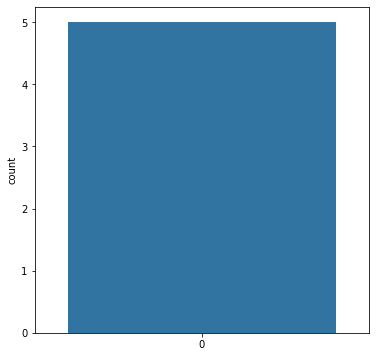

In [48]:
_, axes = plt.subplots(1, 1, figsize=(6, 6))
sns.countplot(data=np.bincount(result[0]), ax=axes);

## Dataset class

In [6]:
class CassavaDataset(Dataset):
    """Cassave leaf disease detection dataset."""

    def __init__(self, csv_file, root_dir, transform=None, idx_list=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            idx_list (list of ints): select only certain rows from csv 
        """
        self.cassava_leaf_disease = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        if idx_list != None:
            self.cassava_leaf_disease = self.cassava_leaf_disease.iloc[idx_list, :]


    def __len__(self):
        return len(self.cassava_leaf_disease)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.cassava_leaf_disease.iloc[idx, 0])
        image = Image.open(img_name)
        if self.transform != None:
            image = self.transform(image)
        
        label = np.array(self.cassava_leaf_disease.iloc[idx, 1])
        return (image, label)

## Transforms and Dataloader

In [7]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45.0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [12]:
cassava_train_dataset = CassavaDataset( csv_file=cfg['train_csv_path'],
                                        root_dir=cfg['train_img_path'],
                                        transform=train_transforms, idx_list=[1,2])

In [13]:
len(cassava_train_dataset)

2

In [14]:
for i in range(len(cassava_train_dataset)):
    print(cassava_train_dataset[0][0].shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
NUM_INSTANCES = len(cassava_train_dataset)
TEST_RATIO = 0.3
VAL_SIZE = int(NUM_INSTANCES * 0.3)
TRAIN_SIZE = NUM_INSTANCES - VAL_SIZE
print(NUM_INSTANCES, TRAIN_SIZE, VAL_SIZE)

In [ ]:
train_ds, val_ds = torch.utils.data.random_split(cassava_train_dataset, (TRAIN_SIZE, VAL_SIZE))
print(len(train_ds), len(val_ds))

## Pretrained model

In [ ]:
class PretrainedModel(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnet34(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, output_features)
        self.model = model
        
    def forward(self, x):
        return self.model(x)

In [ ]:
checkpoint = Checkpoint(f_params='best_model.pt', monitor='valid_acc_best')
freezer = Freezer(lambda x: not x.startswith('model.fc'))

In [ ]:
net = NeuralNetClassifier(
    PretrainedModel, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    max_epochs=5,
    module__output_features=5,
    optimizer=optim.Adam,
    iterator_train__shuffle=cfg['train_data_loader']['shuffle'],
    iterator_train__num_workers= cfg['train_data_loader']['num_workers'],
    iterator_valid__shuffle=cfg['val_data_loader']['shuffle'],
    iterator_valid__num_workers=cfg['val_data_loader']['num_workers'],
    train_split= predefined_split(val_ds), #skorch.dataset.CVSplit(cv=0.3, stratified=True),
    callbacks=[checkpoint, freezer],
    device='cuda' # comment to train on cpu
)

In [ ]:
net.fit(train_ds, y=None);

## Device, loss fn, optimizer